# Data Cleaning
In this lab we will retrieve and clean a public dataset.

## Wine Dataset
Let us start describing the dataset we will be working on. The dataset can be downloaded from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). This dataset contains samples from the *vinho verde* wine producer both for white and red wine.The goal is to model wine quality based on physicochemical tests.

In [1]:
using CSV
red_wine_data = CSV.read("data/winequality-red.csv";delim = ";",types=[Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64]);

INFO: Recompiling stale cache file /Users/dvillacis/.julia/lib/v0.6/CodecZlib.ji for module CodecZlib.
INFO: Recompiling stale cache file /Users/dvillacis/.julia/lib/v0.6/CSV.ji for module CSV.


In [2]:
names(red_wine_data)

12-element Array{Symbol,1}:
 Symbol("fixed acidity")       
 Symbol("volatile acidity")    
 Symbol("citric acid")         
 Symbol("residual sugar")      
 :chlorides                    
 Symbol("free sulfur dioxide") 
 Symbol("total sulfur dioxide")
 :density                      
 :pH                           
 :sulphates                    
 :alcohol                      
 :quality                      

In [3]:
size(red_wine_data)

(1599, 12)

In [5]:
using DataFrames
head(red_wine_data)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
2,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5.0
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5.0
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6.0
5,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5.0
6,7.4,0.66,0.0,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5.0


In [6]:
mean(red_wine_data[:density])

0.996746679174484

In [7]:
means = colwise(mean, red_wine_data)

12-element Array{Float64,1}:
  8.31964  
  0.527821 
  0.270976 
  2.53881  
  0.0874665
 15.8746   
 46.4678   
  0.996747 
  3.31111  
  0.658149 
 10.423    
  5.63602  

In [8]:
stddev = colwise(std, red_wine_data)

12-element Array{Float64,1}:
  1.7411    
  0.17906   
  0.194801  
  1.40993   
  0.0470653 
 10.4594    
 32.8953    
  0.00188733
  0.154386  
  0.169507  
  1.06567   
  0.807569  

## Data Normalization

In [9]:
function normalize_df(df::DataFrame, cols::Array{Int})
   norm_df = df
    for i in cols
        norm_df[i] = (df[i]-minimum(df[i])) / (maximum(df[i])-minimum(df[i]))
    end
    return norm_df
end

normalize_df (generic function with 1 method)

In [14]:
red_wine_data_norm = normalize_df(red_wine_data,[1:11...]);
head(red_wine_data_norm)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1,0.247788,0.39726,0.0,0.0684932,0.106845,0.140845,0.0989399,0.567548,0.606299,0.137725,0.153846,5.0
2,0.283186,0.520548,0.0,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,5.0
3,0.283186,0.438356,0.04,0.0958904,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,5.0
4,0.584071,0.109589,0.56,0.0684932,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,6.0
5,0.247788,0.39726,0.0,0.0684932,0.106845,0.140845,0.0989399,0.567548,0.606299,0.137725,0.153846,5.0
6,0.247788,0.369863,0.0,0.0616438,0.105175,0.169014,0.120141,0.567548,0.606299,0.137725,0.153846,5.0


## Plotting

In [15]:
using StatPlots

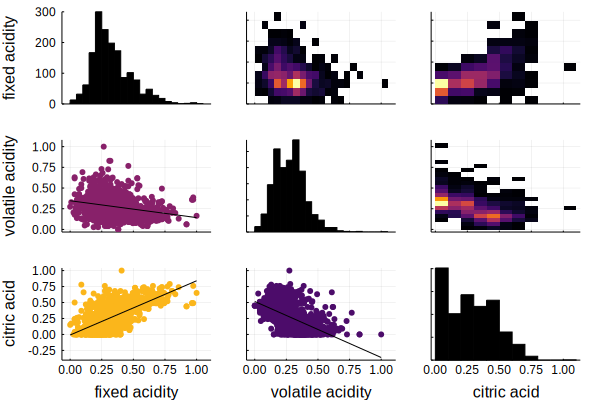

In [18]:
@df red_wine_data_norm corrplot(cols(1:3),grid=true)

## Saving the cleaned data

In [22]:
function sample(df, fraction::Real, seed::Integer)
    # copy
    norm_df = deepcopy(df)

    # rows
    (rows,) = size(norm_df)

    # split
    train_index, test_index = sample_indices(rows, fraction, seed)

    # handle the response difference of an array/vector and a matrix
    if typeof(norm_df) <: Array || typeof(norm_df) <: Vector
        return norm_df[train_index], norm_df[test_index]
    else
        return norm_df[train_index, :], norm_df[test_index, :]
    end
end

# Returns the indicies for each set
function sample_indices(rows::Integer, fraction::Real, seed::Integer)
    # index all rows
    indices = [1:rows;]

    # shuffle indicies to a reproducable set based on seed
    indices = seeded_shuffle(indices, seed)

    # round to integer based on a % of rows
    index = round(Integer, rows * fraction)

    return indices[1:index], indices[(index + 1):rows]
end

# Shuffles an array in a repeatable manner, if the same seed is provided.
function seeded_shuffle(indices, seed::Integer)
    # Create a new randomizer
    mt = Base.Random.MersenneTwister(seed)

    # Seed for replicable random
    srand(seed)

    return shuffle(mt, indices)
end

seeded_shuffle (generic function with 1 method)

In [29]:
training_set, test_set = sample(red_wine_data_norm, 0.8, 15);
y_train = training_set[12];
x_train = training_set[1:11];
y_test = test_set[12];
x_test = test_set[1:11];

In [32]:
head(x_train)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1,0.327434,0.123288,0.49,0.19863,0.130217,0.140845,0.0636042,0.360499,0.417323,0.185629,0.569231
2,0.0884956,0.260274,0.09,0.0958904,0.0617696,0.225352,0.328622,0.26652,0.700787,0.179641,0.707692
3,0.230088,0.393836,0.13,0.0753425,0.106845,0.15493,0.04947,0.395742,0.433071,0.125749,0.261538
4,0.212389,0.294521,0.13,0.0890411,0.105175,0.197183,0.102473,0.428047,0.488189,0.155689,0.2
5,0.274336,0.0958904,0.3,0.0547945,0.0784641,0.267606,0.113074,0.354626,0.433071,0.0838323,0.369231
6,0.106195,0.383562,0.02,0.0616438,0.125209,0.28169,0.310954,0.317915,0.629921,0.113772,0.246154


In [35]:
CSV.write("data/clean_data/x_train.csv",x_train);
CSV.write("data/clean_data/x_test.csv",x_test);

In [38]:
writedlm("data/clean_data/y_train.txt",y_train);
writedlm("data/clean_data/y_test.txt",y_test);

In [43]:
using JLD
save("data/clean_data/dataset.jld","x_train", x_train, "x_test", x_test, "y_train", y_train, "y_test", y_test)